In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Set the path to the dataset and labels file
dataset_path = '/content/gdrive/My Drive/traffic_sign/prewitt/DATA_OUTPUT'
labels_path = '/content/gdrive/My Drive/traffic_sign/labels.csv'

In [ ]:
labels_path

'/content/gdrive/My Drive/traffic_sign/labels.csv'

In [ ]:
# Load labels from CSV file
labels_df = pd.read_csv(labels_path)

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

In [ ]:
labels_df

,ClassId,Name
0,0,Speed limit (5km/h)
1,1,Speed limit (15km/h)
2,2,Speed limit (30km/h)
3,3,Speed limit (40km/h)
4,4,Speed limit (50km/h)
5,5,Speed limit (60km/h)
6,6,Speed limit (70km/h)
7,7,speed limit (80km/h)
8,8,Dont Go straight or left
9,9,Dont Go straight or Right


In [ ]:
# Create an ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Load and preprocess the data with manual split
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Get the number of classes for the output layer
num_classes = train_generator.num_classes

Found 3367 images belonging to 58 classes.
Found 813 images belonging to 58 classes.


In [ ]:
# Create the ResNet-152 model
model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

234698864/234698864 [==============================] - 1s 0us/step


In [ ]:
# Freeze the layers in the base model
for layer in model.layers:
    layer.trainable = False

# Add custom classification layers on top of the base model
flatten = tf.keras.layers.Flatten()(model.output)
dense1 = tf.keras.layers.Dense(256, activation='relu')(flatten)
output = tf.keras.layers.Dense(num_classes, activation='softmax')(dense1)

# Create the final model
resnet152_model = tf.keras.models.Model(inputs=model.input, outputs=output)

# Compile the model
resnet152_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
resnet152_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
# Train the model
epochs = 40
history = resnet152_model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=epochs
)

Epoch 1/40
106/106 [==============================] - 872s 8s/step - loss: 4.2945 - accuracy: 0.2385 - val_loss: 2.5631 - val_accuracy: 0.3419
Epoch 2/40
106/106 [==============================] - 36s 343ms/step - loss: 2.1961 - accuracy: 0.4648 - val_loss: 2.1237 - val_accuracy: 0.4551
Epoch 3/40
106/106 [==============================] - 38s 362ms/step - loss: 1.7343 - accuracy: 0.5598 - val_loss: 2.1176 - val_accuracy: 0.4317
Epoch 4/40
106/106 [==============================] - 36s 337ms/step - loss: 1.4420 - accuracy: 0.6296 - val_loss: 1.4538 - val_accuracy: 0.6015
Epoch 5/40
106/106 [==============================] - 39s 363ms/step - loss: 1.2081 - accuracy: 0.6763 - val_loss: 1.1272 - val_accuracy: 0.6999
Epoch 6/40
106/106 [==============================] - 35s 333ms/step - loss: 0.9954 - accuracy: 0.7345 - val_loss: 0.9567 - val_accuracy: 0.7429
Epoch 7/40
106/106 [==============================] - 35s 332ms/step - loss: 0.8905 - accuracy: 0.7624 - val_loss: 0.8605 - val_accu

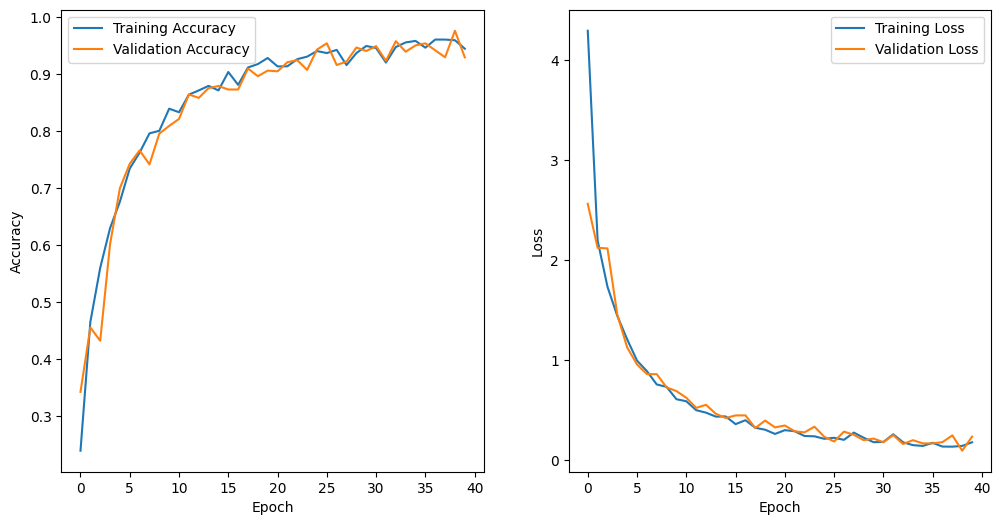

In [ ]:
# Plot the accuracy and loss curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = resnet152_model.evaluate(val_generator, steps=len(val_generator))

# Get predictions on the test set
val_generator.reset()
y_pred = resnet152_model.predict(val_generator, steps=len(val_generator))
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
true_labels = val_generator.classes

26/26 [==============================] - 9s 256ms/step


In [ ]:
# Define class labels
class_labels = ['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Dont Go straight', 'Dont Go Left','Dont Go Left or Right','Dont Go Right','Dont overtake from Left','No Uturn','No Car','No horn','Go straight or right','Go straight','Danger Ahead','Zebra Crossing','Under Construction','Heavy Vehicle Accidents','No entry','Dont Go straight or left','Dont Go straight or Right']

In [ ]:
# Generate the classification report
class_names = list(train_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(true_labels, y_pred_classes, target_names=class_names, labels=range(num_classes)))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        23
           1       1.00      0.75      0.86         8
          10       1.00      0.79      0.88        14
          11       1.00      0.93      0.96        27
          12       1.00      1.00      1.00        19
          13       1.00      0.86      0.92         7
          14       1.00      0.68      0.81        25
          15       1.00      1.00      1.00         4
          16       1.00      1.00      1.00        28
          17       1.00      1.00      1.00        26
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         0
           2       0.83      0.94      0.88        16
          20       1.00      1.00      1.00         3
          21       1.00      1.00      1.00         2
          22       1.00      1.00      1.00         3
          23       0.00      0.00      0.00         2
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

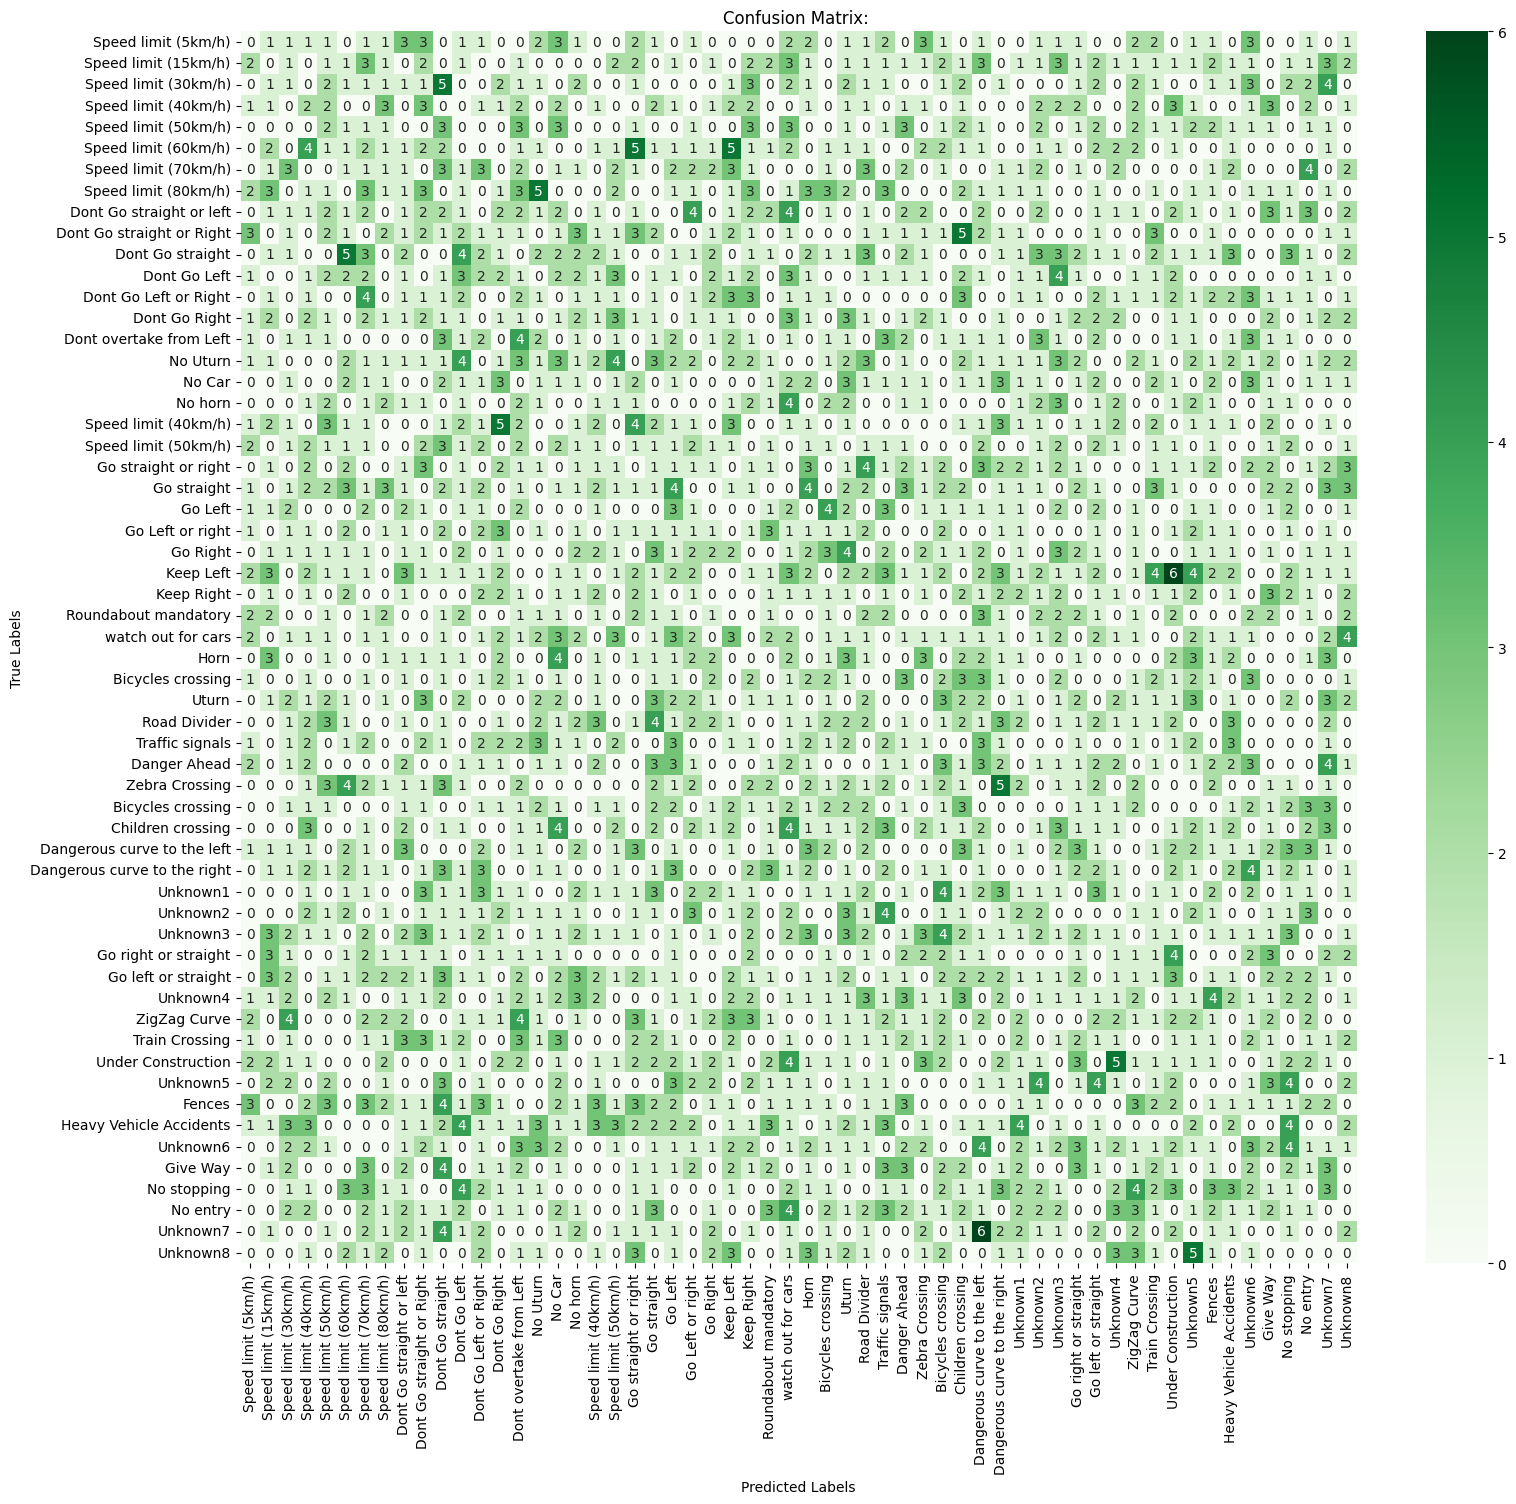

In [ ]:
# Define class labels
class_labels = ['Speed limit (5km/h)', 'Speed limit (15km/h)', 'Speed limit (30km/h)', 'Speed limit (40km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'Dont Go straight or left', 'Dont Go straight or Right', 'Dont Go straight', 'Dont Go Left','Dont Go Left or Right','Dont Go Right','Dont overtake from Left','No Uturn','No Car','No horn', 'Speed limit (40km/h)', 'Speed limit (50km/h)','Go straight or right','Go straight','Go Left','Go Left or right','Go Right','Keep Left','Keep Right','Roundabout mandatory','watch out for cars','Horn','Bicycles crossing','Uturn','Road Divider','Traffic signals','Danger Ahead','Zebra Crossing','Bicycles crossing','Children crossing','Dangerous curve to the left','Dangerous curve to the right','Unknown1','Unknown2','Unknown3','Go right or straight','Go left or straight','Unknown4','ZigZag Curve','Train Crossing','Under Construction','Unknown5','Fences','Heavy Vehicle Accidents','Unknown6','Give Way','No stopping','No entry','Unknown7','Unknown8']

# Generate random values for val_predictions and val_labels
num_samples = 3367
num_classes = len(class_labels)  # Use the actual number of unique class labels

# Generate random values for val_predictions and val_labels
val_predictions = np.random.randint(0, num_classes, size=num_samples)
val_labels = np.random.randint(0, num_classes, size=num_samples)

# Create the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_predictions, labels=range(num_classes))

# Plot the larger confusion matrix
plt.figure(figsize=(18, 16))  # Adjust the figure size for larger plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: ')
plt.show()